In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [198]:
# tables to import are : rental 

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
SELECT c.name as category_name, f.rental_rate, f.rating, f.film_id, f.rental_duration, f.length,
date_format(convert(r.rental_date, date), '%m') as r_month
FROM film f
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON r.inventory_id = i.inventory_id
JOIN film_category fc ON fc.film_id = f.film_id
JOIN category c ON c.category_id = fc.category_id
GROUP BY f.film_id
ORDER BY f.film_id, r_month desc;
        '''

### 2- Read the data into a Pandas dataframe

In [199]:
data = pd.read_sql_query(query, engine)
data

,category_name,rental_rate,rating,film_id,rental_duration,length,r_month
0,Documentary,0.99,PG,1,6,86,07
1,Horror,4.99,G,2,3,48,08
2,Documentary,2.99,NC-17,3,7,50,07
3,Horror,2.99,G,4,5,117,07
4,Family,2.99,G,5,6,130,05
...,...,...,...,...,...,...,...
953,Documentary,0.99,G,996,6,183,07
954,Music,0.99,NC-17,997,4,179,07
955,Horror,0.99,NC-17,998,6,105,06
956,Children,2.99,R,999,5,101,07


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [200]:
# review data shape

data.shape

(958, 7)

In [201]:
# review data types

data.dtypes

category_name       object
rental_rate        float64
rating              object
film_id              int64
rental_duration      int64
length               int64
r_month             object
dtype: object

In [202]:
# headers
# no need to change headers

In [203]:
# inventory is unique so it can be used as index
data = data.set_index('film_id')

In [204]:
# check unique values
# I will not change any of these values as I don't see a need to

for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Children       58
Games          58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category_name, dtype: int64 

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64 

07    427
05    225
06    223
08     83
Name: r_month, dtype: int64 



In [205]:
for col in data.select_dtypes('int64'):
    print(data[col].value_counts(), '\n')

6    203
3    197
4    194
5    186
7    178
Name: rental_duration, dtype: int64 

85     17
84     13
179    13
112    12
73     11
       ..
94      3
66      2
55      2
95      2
96      2
Name: length, Length: 140, dtype: int64 



In [206]:
# check null values
# no null values to correct

data.isna().sum()

category_name      0
rental_rate        0
rating             0
rental_duration    0
length             0
r_month            0
dtype: int64

In [210]:
# change formats
# change rental_rate to string

data['rental_rate'] = data['rental_rate'].astype('str')
data['rental_duration'] = data['rental_duration'].astype('str')

In [211]:
# clean r_month format

def clean_date(x):
    if x.startswith('0'):
        return x.replace("0","")
    else:
        return x

data['r_month'] = pd.to_numeric(data['r_month'].apply(clean_date))

AttributeError: 'int' object has no attribute 'startswith'

In [212]:
data.dtypes

category_name      object
rental_rate        object
rating             object
rental_duration    object
length              int64
r_month             int64
dtype: object

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [213]:
# assumption that current month is September 2005
# create boolean column

current_month = 9
last_month = current_month - 1

data['rented_lm'] = np.where(data['r_month'] == last_month,  True, False)
data.head()

,category_name,rental_rate,rating,rental_duration,length,r_month,rented_lm
film_id,,,,,,,
1,Documentary,0.99,PG,6,86,7,False
2,Horror,4.99,G,3,48,8,True
3,Documentary,2.99,NC-17,7,50,7,False
4,Horror,2.99,G,5,117,7,False
5,Family,2.99,G,6,130,5,False


In [214]:
#pd.crosstab(data['rented_lm'], data['category_name'])
#pd.crosstab(data['rented_lm'], data['rating'])

## EDA

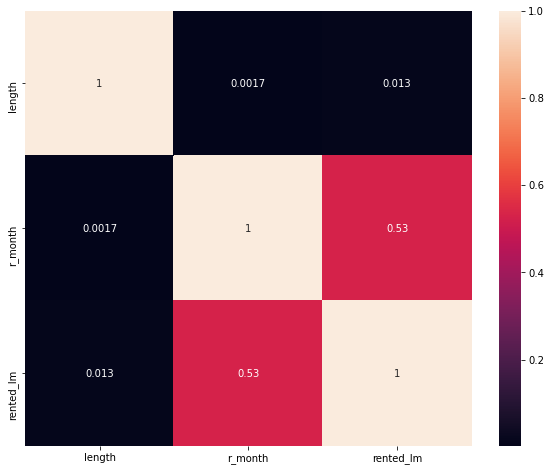

In [215]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [216]:
data = data.drop('r_month', axis=1)

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [217]:
y = data['rented_lm']
X = data.drop('rented_lm', axis=1)

In [218]:
X = pd.get_dummies(X)
X

,length,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,...,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
film_id,,,,,,,,,,,,,,,,,,,,,
1,86,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,48,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,50,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,117,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,130,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,183,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
997,179,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
998,105,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter
classification.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [221]:
classification.score(X_test, y_test)

0.9375

In [222]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

False    192
dtype: int64

In [223]:
y_test.value_counts()

False    180
True      12
Name: rented_lm, dtype: int64

In [224]:
confusion_matrix(y_test, predictions)

array([[180,   0],
       [ 12,   0]], dtype=int64)

<AxesSubplot:>

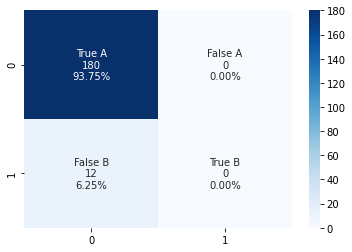

In [225]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A',
               'False B', 'True B']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

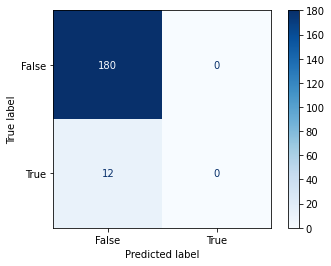

In [226]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

## notes & questions

I tried several different variable combinations (added and removed variables) but always got funny looking results in my confusion matrix and classification score
Can you please help me understand what I did wrong?